In [4]:
from numpy import loadtxt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

[0]	train-auc:0.80582
[1]	train-auc:0.83781


F:\Anaconda\setup\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[2]	train-auc:0.84480
[3]	train-auc:0.84610
[4]	train-auc:0.85292
[5]	train-auc:0.85869
[6]	train-auc:0.86178
[7]	train-auc:0.86640
[8]	train-auc:0.86894
[9]	train-auc:0.87228
[10]	train-auc:0.87467
[11]	train-auc:0.87882
[12]	train-auc:0.88086
[13]	train-auc:0.88244
[14]	train-auc:0.88436
[15]	train-auc:0.88581
[16]	train-auc:0.88862
[17]	train-auc:0.89139
[18]	train-auc:0.89328
[19]	train-auc:0.89425
[20]	train-auc:0.89550
[21]	train-auc:0.89767
[22]	train-auc:0.89911
[23]	train-auc:0.90013
[24]	train-auc:0.90166
[25]	train-auc:0.90298
[26]	train-auc:0.90438
[27]	train-auc:0.90528
[28]	train-auc:0.90609
[29]	train-auc:0.90714
[30]	train-auc:0.90791
[31]	train-auc:0.90942
[32]	train-auc:0.91053
[33]	train-auc:0.91207
[34]	train-auc:0.91331
[35]	train-auc:0.91408
[36]	train-auc:0.91584
[37]	train-auc:0.91685
[38]	train-auc:0.91812
[39]	train-auc:0.91909
[40]	train-auc:0.92009
[41]	train-auc:0.92109
[42]	train-auc:0.92234
[43]	train-auc:0.92369
[44]	train-auc:0.92496
[45]	train-auc:0.92

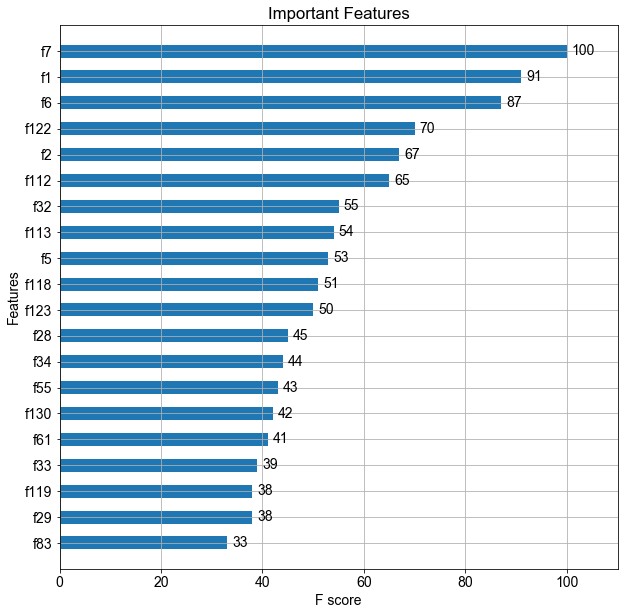

In [49]:
# load data
train_data = loadtxt('train.csv', delimiter=',', skiprows=1)
train_X = train_data[1:,0:162]
train_Y = train_data[1:,162]
validation_data = loadtxt('validation.csv', delimiter=',', skiprows=1)
validation_X = validation_data[1:,0:162]
validation_Y = validation_data[1:,162]
test_data = loadtxt('test.csv', delimiter=',', skiprows=1)
test_X = test_data[1:,0:162]
test_Y = test_data[1:,162]

# xgboost模型初始化设置
dtrain = xgb.DMatrix(train_X, label=train_Y)
dvalid = xgb.DMatrix(validation_X)
dtest = xgb.DMatrix(test_X)
watchlist = [(dtrain, 'train')]

# booster:
params = {  'booster': 'gbtree',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 5,
            'lambda': 10,
            'subsample': 0.75,
            'colsample_bytree': 0.75,
            'min_child_weight': 2,
            'eta': 0.025,
            'seed': 0,
            'nthread': 8,
            'gamma': 0.15,
            'learning_rate' : 0.1  }

# 建模与预测：100棵树
bst = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist)

print("----------for validation data----------")
ypred = bst.predict(dvalid)
# 设置阈值、评价指标
y_pred = (ypred >= 0.5)*1
print ('Precesion: %.4f' %metrics.precision_score(validation_Y,y_pred))
print ('Recall: %.4f' % metrics.recall_score(validation_Y,y_pred))
print ('F1-score: %.4f' %metrics.f1_score(validation_Y,y_pred))
print ('Accuracy: %.4f' % metrics.accuracy_score(validation_Y,y_pred))
print ('AUC: %.4f' % metrics.roc_auc_score(validation_Y,ypred))

ypred = bst.predict(dvalid)
print("验证集每个样本的得分\n",ypred)
ypred_leaf = bst.predict(dvalid, pred_leaf=True)
print("验证集每棵树所属的节点数\n",ypred_leaf)
ypred_contribs = bst.predict(dvalid, pred_contribs=True)
print("特征的重要性\n",ypred_contribs )


print("----------for test data----------")
ypred = bst.predict(dtest)
# 设置阈值、评价指标
y_pred = (ypred >= 0.5)*1
print ('Precesion: %.4f' %metrics.precision_score(test_Y,y_pred))
print ('Recall: %.4f' % metrics.recall_score(test_Y,y_pred))
print ('F1-score: %.4f' %metrics.f1_score(test_Y,y_pred))
print ('Accuracy: %.4f' % metrics.accuracy_score(test_Y,y_pred))
print ('AUC: %.4f' % metrics.roc_auc_score(test_Y,ypred))

ypred = bst.predict(dtest)
print("测试集每个样本的得分\n",ypred)
ypred_leaf = bst.predict(dtest, pred_leaf=True)
print("测试集每棵树所属的节点数\n",ypred_leaf)
ypred_contribs = bst.predict(dtest, pred_contribs=True)
print("特征的重要性\n",ypred_contribs )

# 参数importance_type(string, default “gain”), 其他取值有“weight”, “cover”, “total_gain” or “total_cover”.
# weight:该特征被选为分裂特征的次数; 
# gain: 该特征在它所有分裂使用中带来的平均增益; 
# total_gain: 该特征在它所有分裂使用中带来的增益和; 
# cover: 该特征在它所有分裂使用中的平均覆盖率(覆盖率:受分裂影响的样本数); 
# total_cover: 该特征在它所有分裂使用中的总覆盖率.

fig,ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(bst, ax=ax, height=0.5, max_num_features=20, title='Important Features', ylabel='Features')
plt.rc('font', family='Arial Unicode MS', size=14)
plt.show()